In [1]:
import xarray as xr
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import skill_metrics as sm
# import proplot as pplt

# 泰勒图绘制

2021.08.15

计算年际变化（时间序列）的taylor 图

2021.08.16

继续使用skillmetics包进行

将数据处理为字典，便于按照某个特征进行索引

泰勒图上的每个小点会单独绘制，按照特征给予不同的风格

## 数据读入

读入分区之后的数据

In [2]:
# get partial mask_res collect into a dict
partial_list = ["NE", "NC", "YZ", "SC",'SW','NWC']
path_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_pre"
file_ref = "obsmerge_pre_98-17.nc"
file_vr = "vr_pre_98-17.nc"
file_rcm = "rcm_pre_98-17.nc"

var_partial = {}
for iregion in partial_list:
    path_in_partial = path_in + "/" + iregion + "/ordata/" # refine path
    var_partial[iregion] = {}
    var_partial[iregion]['obs'] = xr.open_dataset(path_in_partial + file_ref)['premerge']
    var_partial[iregion]['vr'] = xr.open_dataset(path_in_partial + file_vr)['precip_MPAS']
    var_partial[iregion]['rcm'] = xr.open_dataset(path_in_partial + file_rcm)['precip_MPAS']
    # print(path_in_partial)
    # partial_res[i] = taylor_count(path_in_partial, file_ref, "pre", file_vr, "precip_MPAS", file_rcm, "precip_MPAS")

    # change coords
    var_list = ['obs', 'vr', 'rcm']
    for i in var_list:
        rename_dict = dict(zip(var_partial[iregion][i].coords.keys(), var_partial[iregion]['obs'].coords.keys()))
    #     # show converting coords
        for rename_i in rename_dict:
            print(rename_i + " -----converting to----- " + rename_dict[rename_i])

        var_partial[iregion][i] = var_partial[iregion][i].rename(rename_dict)
        var_partial[iregion][i]._coords = var_partial[iregion]['obs']._coords
        var_partial[iregion][i] = var_partial[iregion][i].rename(i)

time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
lev -----converting to----- lev
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
lev -----converting to----- lev
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
lev -----converting to----- lev
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to---

## 计算年际时间序列 var_partial_ts

In [3]:
time_sel = {}

time_sel['am'] = var_partial['NC']['obs'].time.dt.month.isin([4,5])
time_sel['jja'] = var_partial['NC']['obs'].time.dt.month.isin([6,7,8])

In [4]:
# 计算年际时间序列：
var_partial_ts = {}
for iregion in partial_list:
    var_partial_ts[iregion] = {}
    for imod in ['obs','vr','rcm']:
        var_partial_ts[iregion][imod] = {}
        for iseason in ['am','jja']:
            var_partial_ts[iregion][imod][iseason] = var_partial[iregion][imod].isel(time = time_sel[iseason]).mean(dim = ['lat','lon'])
            var_partial_ts[iregion][imod][iseason] = \
                var_partial_ts[iregion][imod][iseason].groupby(var_partial_ts[iregion][imod][iseason].time.dt.year).mean()

## 计算泰勒图诸要素，并整理进行绘图

In [5]:
# 计算泰勒图诸要素 到字典taylor_ts中
taylor_ts = {}
for iregion in partial_list:
    taylor_ts[iregion] = {}
    for imod in ['obs','vr','rcm']:
        taylor_ts[iregion][imod] = {}
        for iseason in ['am','jja']:
            taylor_ts[iregion][imod][iseason] = {}
            temp_obs = var_partial_ts[iregion]['obs'][iseason].values
            temp_mod = var_partial_ts[iregion][imod][iseason].values
            taylor_ts[iregion][imod][iseason] = sm.taylor_statistics(temp_mod, temp_obs)
            # normalized
            taylor_ts[iregion][imod][iseason]['sdev'] = taylor_ts[iregion][imod][iseason]['sdev'] / taylor_ts[iregion][imod][iseason]['sdev'][0]
            taylor_ts[iregion][imod][iseason]['crmsd'] = taylor_ts[iregion][imod][iseason]['crmsd'] / taylor_ts[iregion][imod][iseason]['sdev'][0]

## PLOT
逐个点的绘制泰勒图，单独为每个点的属性设置相应的特征

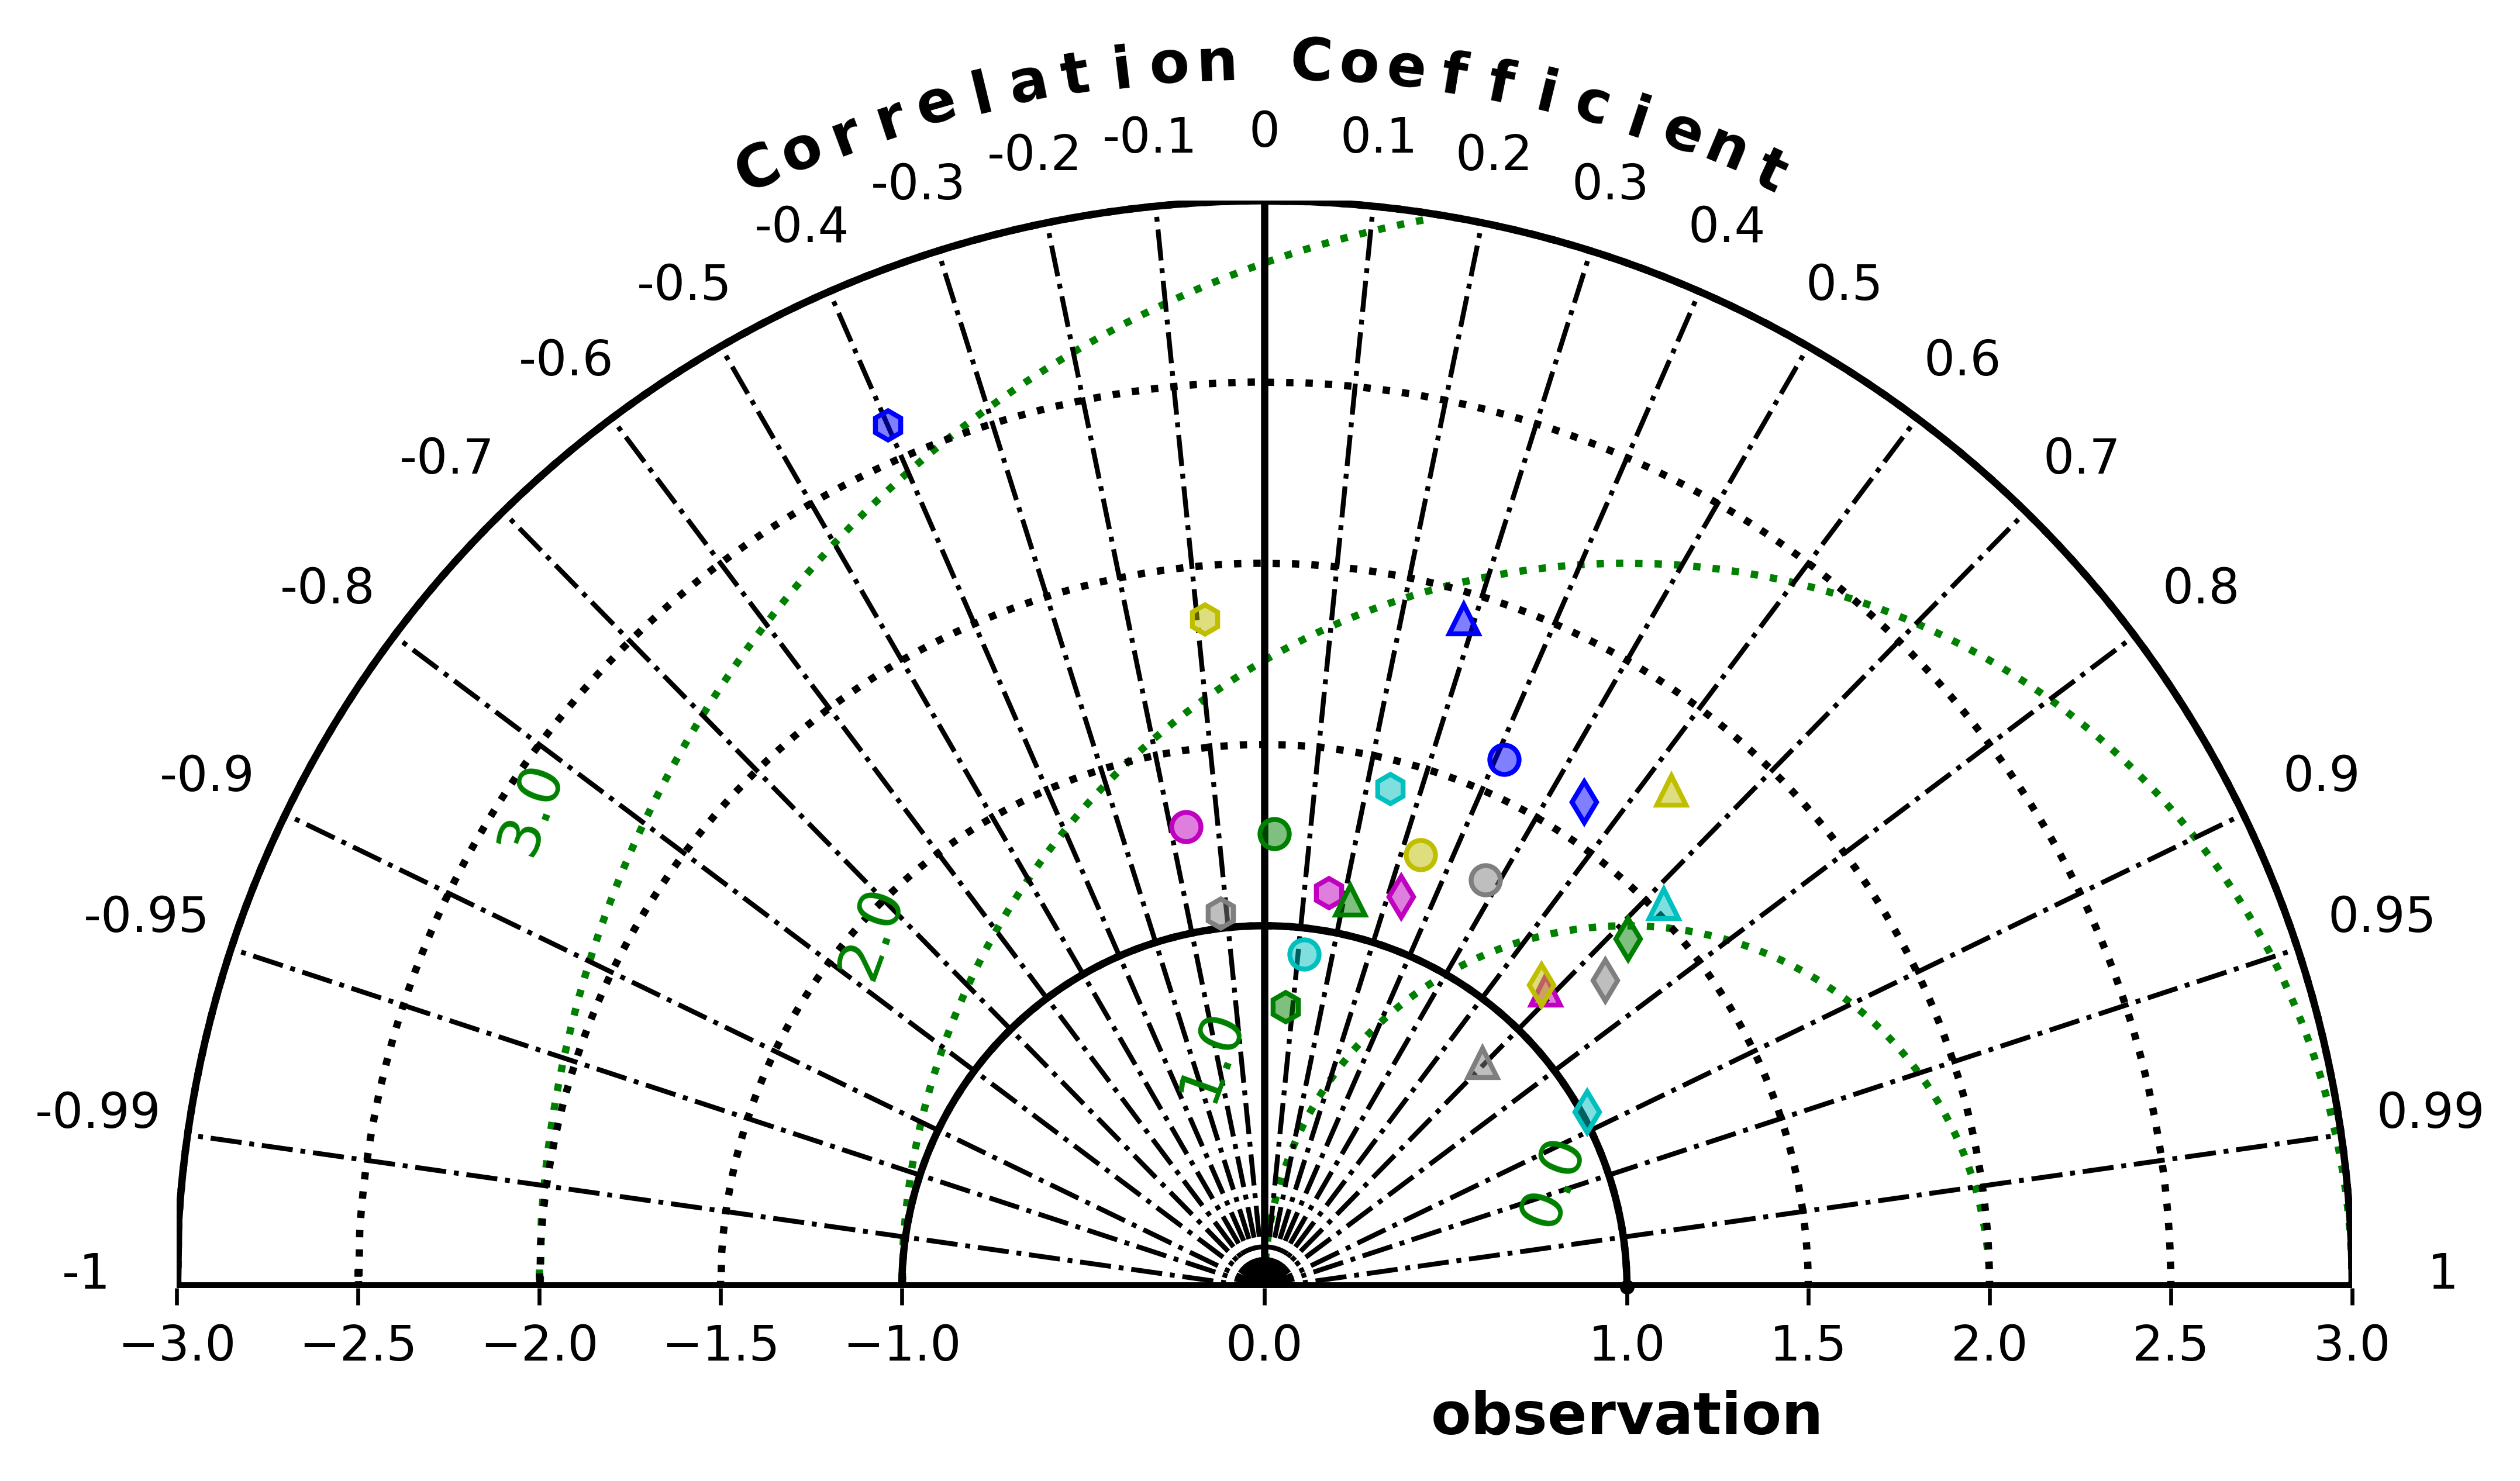

In [6]:
# import skill_metrics as sm
import importlib
importlib.reload(sm)

# fig, axs = pplt.subplots(ncols=1 ,nrows=1)
fig = plt.figure(figsize=(8, 8), dpi=600)

first_plot = False # 用作后续overlay设置

# 创建风格的dict,之后传入每个单独的点来进行绘制
# # Define markers
# kind = ['+','o','x','s','d','^','v','p','h','*']
# colorm = ['b','r','g','c','m','y','k']
imod_style_color = {'vr':"r", 'rcm':'b'}
iregion_style_color = {"NE":"m", "NC":"y", "YZ":"c", "SC":"b",'SW':"g",'NWC':"tab:gray"}
iseason_style_marker = {'am':'.',"jja":'v'}

combine_mod_season_marker = {'vr am':"o","vr jja":"h","rcm am":"d","rcm jja":"^"}


for iregion in partial_list:
    for imod in ['vr','rcm']:
        for iseason in ['am','jja']:
            # 获取每个点的泰勒图诸要素
            sdev_plot = taylor_ts[iregion][imod][iseason]['sdev']
            crmsd_plot = taylor_ts[iregion][imod][iseason]['crmsd']
            ccoef_plot = taylor_ts[iregion][imod][iseason]['ccoef']

            sm.taylor_diagram(sdev_plot,crmsd_plot,ccoef_plot, 
                #----- mark setting -----
                MarkerDisplayed = 'marker',
                # markerLabel = label2, 
                # numberPanels = 1,
                # markerLabel = ['obs','vr','rcm'],
                # markerLabel = ['obs', imod.upper()],
                # markerLabelColor = imod_style_color[imod],
                markerlegend = "off",
                markerColor = iregion_style_color[iregion],
                markerSize = 6,
                alpha = .5, 
                # -----RNSD-----
                # tickRMS = np.arange(0,1.8,0.2),
                tickRMS = [0, 1, 2, 3],
                tickRMSangle = 160, 
                colRMS = 'g', styleRMS = ':', widthRMS = 1.5,
                # tickCOR = lsCOR,
                showlabelsRMS = "on",
                titleRMS = "off",
                rmslabelformat = ':.1f',
                # -----COR-----
                colCOR = "k", 
                widthCOR = 1.0,
                # -----STD------
                tickSTD = [0,1,1.5,2.,2.5, 3], axismax = 3., 
                showlabelsSTD = 'on',
                # markersymbol = iseason_style_marker[iseason],
                markersymbol = combine_mod_season_marker[imod + " " + iseason],
                # -----marker reference-----
                styleOBS = '-', 
                colOBS = 'k',
                markerobs = 'o', 
                overlay = first_plot,
                titleOBS = 'observation',
                # ------ check -----
                checkStats = True,
            )

            first_plot = True


# legend设置，颜色以及型号
# custom legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = []
for i in iregion_style_color.items():
    legend_elements.append( Patch(facecolor=i[1],label=i[0]))
for i in combine_mod_season_marker.items():
    legend_elements.append( Line2D([0], [0], marker=i[1], color='w', label=i[0].upper(),
                          markerfacecolor='k', markersize=6)) 

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(.9,0.75),prop={'size': 6})

#saving pics
plt.savefig("./output_pic/pre_taylor_interannual_ts",dpi=600, facecolor = 'white')